In [8]:
import numpy as np
import pandas as pd
import helpers
import implementation
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [9]:
yb, input_data, ids = helpers.load_csv_data("./data/train.csv")

In [10]:
df_input_data = pd.DataFrame(input_data)

In [11]:
def quantile_normalize(data, q=0.95):
    low    = (1-q) / 2
    high   = 1-low
    q_low  = np.quantile(data, low,  axis=0)
    q_high = np.quantile(data, high, axis=0)
    return (data - q_low) / (q_high - q_low)

def mim_max_normalize(data):
    return (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

def z_normalize(data):
    return (data - data.mean(axis=0)) / data.std(axis=0)

def accuracy(y, tx, w):
    pred    = np.where(implementation.sigmoid(tx.dot(w)) > 0.5, 1, 0)
    correct = np.sum(np.where(pred == y, 1, 0))
    return correct / len(y)

def accuracy2(y, tx, w):
    pred    = np.where(tx.dot(w) > 0, 1, 0)
    correct = np.sum(np.where(pred == y, 1, 0))
    return correct / len(y)

In [12]:
data = np.array(df_input_data)

In [13]:
x = quantile_normalize(data, q=0.75)
y  = np.where(yb > 0, 1, 0)
tx = np.append(np.ones(len(x)).reshape(-1,1), x, axis=1)

In [14]:
lambda_   = 0
initial_w = np.zeros(tx.shape[1])
max_iters = 1000
gamma     = 0.000003
w, loss   = implementation.reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma)
print(accuracy(y, tx, w))

0.749352


In [17]:
w, loss   = implementation.least_squares(yb, tx)
print(accuracy(y, tx, w))

0.744972


In [25]:
def build_k_indices(y, k_fold, seed=0):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [26]:
def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    te_indices = k_indices[k]
    tr_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indices = tr_indices.reshape(-1)
    y_te = y[te_indices]
    y_tr = y[tr_indices]
    tx_te = x[te_indices]
    tx_tr = x[tr_indices]

    w, loss_tr = implementation.reg_logistic_regression(y_tr, tx_tr, lambda_, initial_w, max_iters, gamma)

    accuracy_te = accuracy(y_te, tx_te, w)
    accuracy_tr = accuracy(y_tr, tx_tr, w)
    return accuracy_tr, accuracy_te, w

In [39]:
seed = 7
k_fold = 5
lambdas = np.logspace(-4, 0, 30)
initial_w = np.zeros(tx.shape[1])
max_iters = 2000
gamma     = 0.000003
# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
accuracy_tr = []
accuracy_te = []
# cross validation
for lambda_ in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te,_ = cross_validation(y, tx, k_indices, k, lambda_)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    accuracy_tr.append(np.mean(rmse_tr_tmp))
    accuracy_te.append(np.mean(rmse_te_tmp))

Text(0, 0.5, 'accuracy')

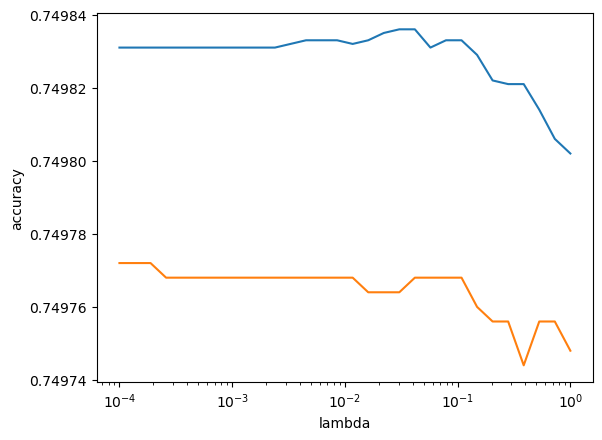

In [40]:
plt.semilogx(lambdas, accuracy_tr)
plt.semilogx(lambdas, accuracy_te)

plt.xlabel('lambda')
plt.ylabel('accuracy')